In [1]:
%cd drive/MyDrive/Fall23/Research/ml_1m/
!ls

/content/drive/MyDrive/Fall23/Research/ml_1m
create_ml1m_dataset.ipynb  ml_1m_dataprocessing.ipynb	     ml_1m_user_profile_generation.ipynb
ml_1m			   ml_1m_item_desc_generation.ipynb


In [2]:
!pip install tenacity
!pip install tiktoken
!pip install termcolor
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.0 MB/s eta 0:00:00
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 10.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)


In [1]:
from collections import defaultdict
from datetime import datetime
import pandas as pd
import json
import numpy as np
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored

In [2]:
openai.api_key = userdata.get('OPENAI_API_KEY')

NameError: name 'userdata' is not defined

In [3]:
user_data = pd.read_csv('./ml_1m/users.csv')
user_data.head()

,user_id,user_profile
0,1,female k-12 student under 18 years of age
1,2,male self-employed above 56 years of age
2,3,male scientist between 25 to 34 years of age
3,4,male executive/managerial between 45 to 49 yea...
4,5,male writer between 25 to 34 years of age


In [4]:
movies_data = pd.read_csv('./ml_1m/movie_summary_25_words.csv')
movies_data.head()

,movie_id,name,cleaned_genre,year,summary
0,1,Toy Story,"Animation,Children's,Comedy",1995,Toy Story is a groundbreaking animated film th...
1,2,Jumanji,"Adventure,Children's,Fantasy",1995,"""Jumanji (1995) is a thrilling adventure film ..."
2,3,Grumpier Old Men,"Comedy,Romance",1995,"""Grumpier Old Men is a hilarious and heartwarm..."
3,4,Waiting to Exhale,"Comedy,Drama",1995,"""Waiting to Exhale"" (1995) is a heartfelt dram..."
4,5,Father of the Bride Part II,Comedy,1995,Father of the Bride Part II (1995) is a heartw...


In [5]:
ratings_data = pd.read_csv('./ml_1m/ratings.csv')
print(ratings_data.shape)
ratings_data.head()

(1000209, 3)


,user_id,movie_id,rating
0,1,3186,4
1,1,1721,4
2,1,1022,5
3,1,1270,5
4,1,2340,3


In [10]:
k_cores = [5, 7, 10, 15, 20, 25, 30, 35, 50, 100]
grouped_by_user_df = ratings_data.groupby('user_id')
for k_core in k_cores:
    ratings_kcore = grouped_by_user_df.filter(lambda x: len(x) >= k_core)
    print(ratings_kcore['user_id'].nunique())

6040
6040
6040
6040
6040
5624
5289
5019
4297
2945


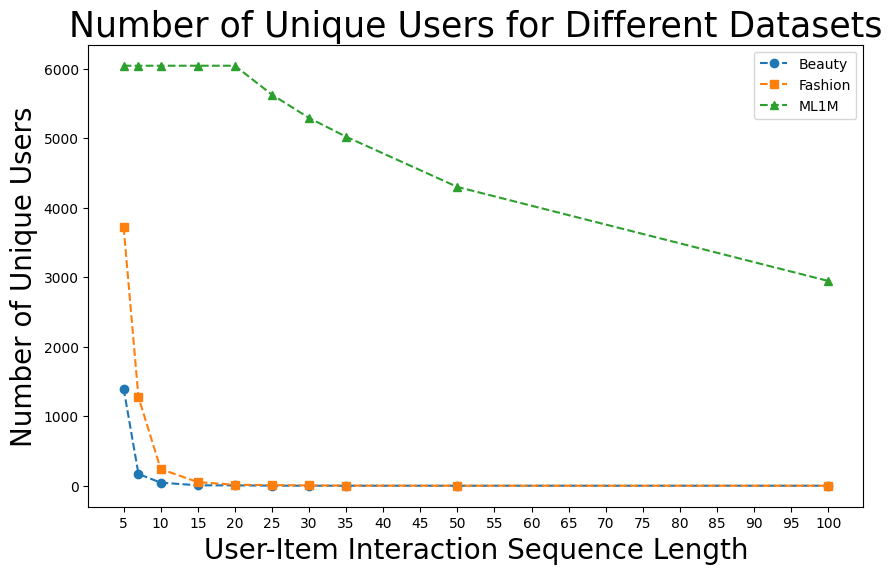

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Data for the plot
k_core = [5, 7, 10, 15, 20, 25, 30, 35, 50, 100]
beauty_users = [1398,169,44,6,5,1,0,0,0,0]
fashion_users = [3718,1273,240,52,14,9,4,2,0,0]
ml1m_users = [6040, 6040, 6040, 6040, 6040, 5624, 5289, 5019, 4297, 2945]

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting the lines for each dataset
plt.plot(k_core, beauty_users, label='Beauty', marker='o', linestyle='--')
plt.plot(k_core, fashion_users, label='Fashion', marker='s', linestyle='--')
plt.plot(k_core, ml1m_users, label='ML1M', marker='^', linestyle='--')

# Adding titles and labels
plt.title('Number of Unique Users for Different Datasets', fontsize=25)
plt.xlabel('User-Item Interaction Sequence Length', fontsize=20)
plt.ylabel('Number of Unique Users', fontsize=20)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

# Adding a legend
plt.legend()

# Showing the plot
plt.grid(False)
plt.show()

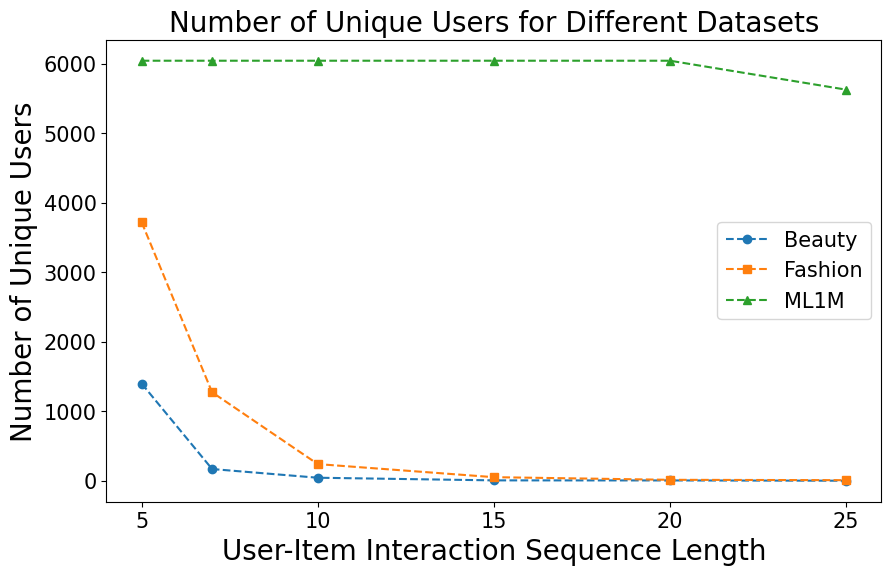

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Data for the plot
k_core = [5, 7, 10, 15, 20, 25]
beauty_users = [1398,169,44,6,5,1]
fashion_users = [3718,1273,240,52,14,9]
ml1m_users = [6040, 6040, 6040, 6040, 6040, 5624]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.rc('font', size=15)

# Plotting the lines for each dataset
plt.plot(k_core, beauty_users, label='Beauty', marker='o', linestyle='--')
plt.plot(k_core, fashion_users, label='Fashion', marker='s', linestyle='--')
plt.plot(k_core, ml1m_users, label='ML1M', marker='^', linestyle='--')

# Adding titles and labels
plt.title('Number of Unique Users for Different Datasets', fontsize=20)
plt.xlabel('User-Item Interaction Sequence Length', fontsize=20)
plt.ylabel('Number of Unique Users', fontsize=20)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

# Adding a legend
plt.legend()

# Showing the plot
plt.grid(False)
plt.show()

In [6]:
all_users = list(ratings_data.user_id.unique())
print(len(all_users), all_users)

6040 [1, 10, 100, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 101, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 102, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 103, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 104, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 105, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 106, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 107, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 108, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 109, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 11, 110, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 111, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 112, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 113, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 114, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 115, 115

In [7]:
from collections import defaultdict
user_movie_dict= defaultdict(list)
cnt = 0
for idx, row in ratings_data.iterrows():
  cnt += 1
  user_movie_dict[row['user_id']].append(row['movie_id'])
print(cnt)

1000209


In [10]:
print(len(user_movie_dict))

6040


In [11]:
min_num_movies_per_user = float('inf')
max_num_movies_per_user = float('-inf')
for k, v in user_movie_dict.items():
  min_num_movies_per_user = min(min_num_movies_per_user, len(v))
  max_num_movies_per_user = max(max_num_movies_per_user, len(v))
print(min_num_movies_per_user, max_num_movies_per_user)

20 2314


### Plain data split
train[16:-2], val[-2], test[-1]

In [12]:
min_movies_req = 20
min_movies_user_bias = 15
max_movies_before_partition = 50

user_train = defaultdict(list)
user_valid = defaultdict(list)
user_test = defaultdict(list)

for u, v in user_movie_dict.items():
  if len(v) < min_movies_req:### Keep only more than 20 movies
    continue
  user_train[u].append(v[15:-2])
  user_valid[u].append(v[-2])
  user_test[u].append(v[-1])

In [18]:
print(user_train[1])
print(user_valid[1])
print(user_test[1])

[[1961, 2028, 3105, 938, 1962, 1035, 150, 2018, 1028, 1097, 914, 2797, 1287, 2762, 1246, 661, 2918, 531, 3114, 2791, 1029, 2321, 1197, 594, 2398, 1545, 527, 1, 588, 2687, 745, 595, 2294, 783, 2355, 1907]]
[1566]
[48]


In [19]:
import pickle

f = open("./ml_1m/user_train.pkl","wb")
pickle.dump(user_train,f)
f.close()
f1 = open("./ml_1m/user_valid.pkl", "wb")
pickle.dump(user_valid, f1)
f1.close()
f2 = open("./ml_1m/user_test.pkl","wb")
pickle.dump(user_test,f2)
f2.close()
f3 = open("./ml_1m/user_movie_dict.pkl", "wb")
pickle.dump(user_movie_dict, f3)
f3.close()

### Idea is as follows:

**User Profile Bias -** Consider the first 15 movies as user bias - generate user profile from that and keep it intact.<br>
 - If number of movies watched in [20, 30] then use it as train, val, test (:-3, -2, -1)
 - else randomly generate a number between 15 and n-2, if number-15 < 15, add 10 to it.
 - if number of movies > 100, then partition 2 times
 - if number of movies >500 and <1000, then partition 3 times in train
 - if number of movies > 1000, then partition 4 times
1. *Update user profile* from first max(15, n-50) but take the movies with rating 5 and 1. This will create a user bias towards specific genres<br>
2. Take the polarizing ratings for first max(15, n-50) movies (this will also reduce the number of movies to summarize)
3. Then for the last min(n-15, 50) movies, take all the movie, this will be more like giving more focus to the recent movies in a case-by-case basis.

*Option2: Use Batch after creating User profile bias*

In [ ]:
from random import seed
from random import gauss, randint
seed(42)

min_movies_req = 20
min_movies_user_bias = 15
max_movies_before_partition = 50

user_train = defaultdict(list)
user_valid = defaultdict(list)
user_test = defaultdict(list)

for u, v in user_movie_dict.items():
  if len(v) < min_movies_req:### Keep only more than 20 movies
    continue
  elif min_movies_req <= len(v) <= max_movies_before_partition:
    ### Just do a train[:-2], val[-2], and test[-1]
    user_train[u].append(v[16:-2])
    user_valid[u].append(v[-2])
    user_test[u].append(v[-1])
    continue

  num_movies_watched = len(v)
  if num_movies_watched > 2000:
    ### 4 time patition
    equal_div = num_movies_watched//4

    user_train[u].append(v[16:equal_div-2])
    user_valid[u].append(v[equal_div-2])
    user_test[u].append(v[equal_div-1])
    num_parts = 1

    while num_parts < 4:
      user_train[u].append(v[equal_div*num_parts:equal_div*(num_parts+1)-2])
      user_valid[u].append(v[equal_div*(num_parts+1)-2])
      user_test[u].append(v[equal_div*(num_parts+1)-1])
      num_parts += 1

  elif num_movies_watched > 500:
    ### 3 time partition
    equal_div = num_movies_watched//3

    user_train[u].append(v[16:equal_div-2])
    user_valid[u].append(v[equal_div-2])
    user_test[u].append(v[equal_div-1])
    num_parts = 1

    while num_parts < 3:
      user_train[u].append(v[equal_div*num_parts:equal_div*(num_parts+1)-2])
      user_valid[u].append(v[equal_div*(num_parts+1)-2])
      user_test[u].append(v[equal_div*(num_parts+1)-1])
      num_parts += 1

  elif num_movies_watched > 100:
    ### 2 time partition
    equal_div = num_movies_watched//2

    user_train[u].append(v[16:equal_div-2])
    user_valid[u].append(v[equal_div-2])
    user_test[u].append(v[equal_div-1])
    num_parts = 1

    while num_parts < 2:
      user_train[u].append(v[equal_div*num_parts:equal_div*(num_parts+1)-2])
      user_valid[u].append(v[equal_div*(num_parts+1)-2])
      user_test[u].append(v[equal_div*(num_parts+1)-1])
      num_parts += 1

  else:
    ### 1 time partition
    partnum = min(int(abs(gauss(0,0.5)) * randint(num_movies_watched-50, num_movies_watched-2)), num_movies_watched-2)
    user_train[u].append(v[16:partnum])
    user_valid[u].append(v[partnum])
    user_test[u].append(v[partnum+1])

In [ ]:
# print(len(user_train))
# print(len(user_valid))
# print(len(user_test))
for u in user_train:
  assert len(user_train[u]) == len(user_valid[u]) == len(user_test[u]), f"Not matching at {u}"
#   print(len(user_train[u]), len(user_valid[u]), len(user_test[u]))

In [ ]:
import pickle

f = open("./ml_1m/partitioned_user_train.pkl","wb")
pickle.dump(user_train,f)
f.close()
f1 = open("./ml_1m/partitioned_user_valid.pkl", "wb")
pickle.dump(user_test, f1)
f1.close()
f2 = open("./ml_1m/partitioned_user_test.pkl","wb")
pickle.dump(user_test,f2)
f2.close()